In [1]:
!python -V

Python 3.9.12


In [3]:
!pip install --upgrade pip

     |████████████████████████████████| 1.8 MB 23.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [24]:
# !pip install pyarrow
!pip install -U scikit-learn

In [4]:
!pip install "numpy==1.26.4"
import numpy as np

In [5]:
import pandas as pd

In [6]:
pd.__version__

'1.4.2'

In [7]:
import seaborn as sns
import matplotlib.pyplot as plot

/home/codespace/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
!pip install pyarrow

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [9]:
import sklearn

In [10]:
sklearn.__version__

'1.6.1'

In [14]:
df= pd.read_parquet('../notebooks/data/yellow_tripdata_2023-01.parquet')

In [4]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

# Q1


In [15]:
len(df.columns)

19

# Q2

In [16]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration_min'] = round(df[df.tpep_pickup_datetime.dt.month ==1].duration.dt.total_seconds() /60 , 2)

In [8]:
round(df[df.tpep_pickup_datetime.dt.month ==1]['duration_min'].std(),2)

42.59

# Q3

In [17]:
df.duration_min.describe(percentiles=[0.95, 0.98, 0.99])

count    3.066718e+06
mean     1.566837e+01
std      4.258564e+01
min     -2.920000e+01
50%      1.152000e+01
95%      3.647000e+01
98%      4.873000e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration_min, dtype: float64

In [18]:
df[(df.duration_min>=1) & (df.duration_min<=60)].duration_min.describe(percentiles=[0.95, 0.98, 0.99])

count    3.009136e+06
mean     1.420488e+01
std      9.939403e+00
min      1.000000e+00
50%      1.155000e+01
95%      3.477000e+01
98%      4.450000e+01
99%      5.027000e+01
max      6.000000e+01
Name: duration_min, dtype: float64

In [19]:
((df.duration_min>=1) & (df.duration_min<=60)).mean()

0.9812082173860021

# Q4

In [20]:
df = df[(df.duration_min >= 1) & (df.duration_min <= 60)]

In [21]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [22]:
df[categorical]=df[categorical].astype(str)

In [23]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [24]:
len(dv.feature_names_)

516

# Q5

In [25]:
target= 'duration_min'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


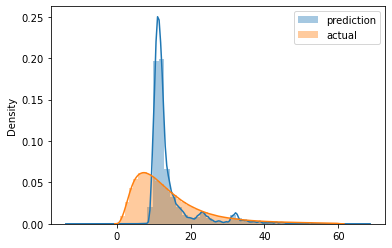

In [27]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plot.legend()

In [28]:
np.sqrt(mean_squared_error(y_train, y_pred))

7.649120950227308

# Q6

In [29]:
def read_datarfame(filename):
    df = pd.read_parquet(filename)

    # #### Next:
    # we will calculate the "duration" in minutes, and plot the distribution of it.

    df['duration']= df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical]=df[categorical].astype(str)
    
    return df

In [30]:
df_train = read_datarfame('../notebooks/data/yellow_tripdata_2023-01.parquet')
df_val = read_datarfame('../notebooks/data/yellow_tripdata_2023-02.parquet')

In [31]:
len(df_train), len(df_val)

(3009173, 2855951)

In [32]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' +df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' +df_val['DOLocationID']

In [33]:
categorical = ['PU_DO'] # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [34]:
target= 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

5.198276637365815